.
..............................................................................................................................................................................................................................## **Preprocessing** **part**

Install necessary function

In [ ]:
!pip install torch torchvision
!pip install opencv-python

import json
import numpy as np
import cv2
import torch
import os
from torch.utils.data import Dataset
from torchvision import transforms
from google.colab import drive
from tqdm import tqdm

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Augmentation

In [ ]:
base_dir = '/content/drive/My Drive/dataset/'
output_dir = base_dir + 'augmented-examples/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
def keystoint(x):
    """ Convert dictionary keys to integers, useful for JSON keys. """
    return {int(k): v for k, v in x.items()}

def rotateVideo(path, output_dir, video_id, degree):
    """ Rotate the video by a specified degree and save it. """

    video = cv2.VideoCapture(path)
    frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = video.get(cv2.CAP_PROP_FPS)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out_rotate = cv2.VideoWriter(output_dir + video_id + "_rotate_" + str(degree) + ".mp4", fourcc, fps, (frame_width, frame_height))

    while video.isOpened():
        success, frame = video.read()
        if not success:
            break

        rotation_matrix = cv2.getRotationMatrix2D((frame_width / 2, frame_height / 2), degree, 1)
        rotated_frame = cv2.warpAffine(frame, rotation_matrix, (frame_width, frame_height))
        out_rotate.write(rotated_frame)

    video.release()
    out_rotate.release()

def translateVideo(path, output_dir, video_id, translate=(0, 0)):
    """ Translate the video by specified pixels and save it. """
    video = cv2.VideoCapture(path)
    frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = video.get(cv2.CAP_PROP_FPS)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out_translate = cv2.VideoWriter(output_dir + video_id + "_translate_" + str(translate[0]) + "_" + str(translate[1]) + ".mp4", fourcc, fps, (frame_width, frame_height))

    while video.isOpened():
        success, frame = video.read()
        if not success:
            break

        M = np.float32([[1, 0, translate[0]], [0, 1, translate[1]]])
        dst = cv2.warpAffine(frame, M, (frame_width, frame_height))
        out_translate.write(dst)

    video.release()
    out_translate.release()

def augmentVideo(annotation_dict, labels_dict, data_dir=base_dir + 'examples/', output_dir=base_dir + 'augmented-examples/'):
    """ Augment videos with rotation and translation transformations. """
    with open(annotation_dict, 'r') as f:
        annotation_dict = json.load(f)
        video_list = list(annotation_dict.items())

    with open(labels_dict, 'r') as f:
        labels_dict = json.load(f,object_hook=keystoint)

    # Count the distribution of actions
    count_dict = dict()
    for key, value in annotation_dict.items():
        action = labels_dict[value]
        if action in count_dict:
            count_dict[action] += 1
        else:
            count_dict[action] = 1

    # Find actions with fewer than 2000 examples
    filtered_actions = [action for action, count in count_dict.items() if count <= 2000]

    # Prepare to augment videos
    augmented_annotation = dict()
    pbar = tqdm(video_list)
    for video_id, action in pbar:
        if labels_dict[action] in filtered_actions:
            path = data_dir + video_id + ".mp4"

            # Rotate and translate the video, save augmented videos
            augmented_annotation[video_id + "_rotate_30"] = action
            rotateVideo(path, output_dir, video_id, 30)

            augmented_annotation[video_id + "_rotate_330"] = action
            rotateVideo(path, output_dir, video_id, 330)

            augmented_annotation[video_id + "_translate_32_0"] = action
            translateVideo(path, output_dir, video_id, (32, 0))

            augmented_annotation[video_id + "_translate_-32_0"] = action
            translateVideo(path, output_dir, video_id, (-32, 0))

    # Save new annotations
    with open(output_dir + 'augmented_annotation_dict.json', 'w') as fp:
        json.dump(augmented_annotation, fp)

if __name__ == "__main__":
    augmentVideo(base_dir + "annotation_dict.json", base_dir + "labels_dict.json")


100%|██████████| 37085/37085 [32:01<00:00, 19.30it/s]


Loading data

In [ ]:
import json

def load_dict_from_json(file_path):
    with open(file_path) as f:
        return json.load(f)

def count_samples(annotation_dict_path, label_dict_path):
    annotation_dict = load_dict_from_json(annotation_dict_path)
    label_dict = load_dict_from_json(label_dict_path)

    total_samples = len(annotation_dict)
    class_counts = {label: 0 for label in set(label_dict.values()) if label != "discard"}

    for video_id, label_index in annotation_dict.items():
        label = label_dict[str(label_index)]
        if label != "discard":
            class_counts[label] += 1

    return total_samples, class_counts

# 設置 annotation_dict 和 label_dict 的路徑
annotation_dict_path = '/content/drive/My Drive/dataset/annotation_dict.json'
label_dict_path = '/content/drive/My Drive/dataset/labels_dict.json'

# 計算總樣本數和各個類別的數量
total_samples, class_counts = count_samples(annotation_dict_path, label_dict_path)

print("Total samples:", total_samples)
print("Class counts:")
for label, count in class_counts.items():
    print(f"{label}: {count}")


Total samples: 37085
Class counts:
block: 996
walk: 11749
defense: 3866
pass: 1070
no_action: 6490
run: 5924
shoot: 426
dribble: 3490
pick: 712
ball in hand: 2362


In [ ]:
import json

def load_dict_from_json(file_path):
    with open(file_path) as f:
        return json.load(f)

def count_samples(annotation_dict_path, label_dict_path):
    annotation_dict = load_dict_from_json(annotation_dict_path)
    label_dict = load_dict_from_json(label_dict_path)

    total_samples = len(annotation_dict)
    class_counts = {label: 0 for label in set(label_dict.values()) if label != "discard"}

    for video_id, label_index in annotation_dict.items():
        label = label_dict[str(label_index)]
        if label != "discard":
            class_counts[label] += 1

    return total_samples, class_counts

# 設置 annotation_dict 和 label_dict 的路徑
annotation_dict_path = '/content/drive/My Drive/dataset/augmented_annotation_dict.json'
label_dict_path = '/content/drive/My Drive/dataset/labels_dict.json'

# 計算總樣本數和各個類別的數量
total_samples, class_counts = count_samples(annotation_dict_path, label_dict_path)

print("Total samples:", total_samples)
print("Class counts:")
for label, count in class_counts.items():
    print(f"{label}: {count}")

Total samples: 12814
Class counts:
block: 3982
walk: 0
defense: 0
pass: 4280
no_action: 0
run: 0
shoot: 1704
dribble: 0
pick: 2848
ball in hand: 0


In [ ]:
import json
import numpy as np
import cv2

import torch
from torch.utils.data import Dataset
from torchvision import transforms
base_dir = '/content/drive/My Drive/dataset/'
class BasketballDataset(Dataset):
    """SpaceJam: a Dataset for Basketball Action Recognition."""

    def __init__(self, annotation_dict, augmented_dict, video_dir=base_dir+"examples/", augmented_dir=base_dir+"augmented-examples/", augment=True, transform=None, poseData=False):
        with open(annotation_dict) as f:
            self.video_list = list(json.load(f).items())

        if augment == True:
            self.augment = augment
            with open(augmented_dict) as f:
                augmented_list = list(json.load(f).items())
            self.augmented_dir = augmented_dir
            # extend with augmented data
            self.video_list.extend(augmented_list)

        self.video_dir = video_dir
        self.poseData = poseData
        self.transform = transform

    def __len__(self):
        # return length of none-flipped videos in directory
        return len(self.video_list)

    def __getitem__(self, idx):
        video_id = self.video_list[idx][0]
        encoding = np.squeeze(np.eye(10)[np.array([0,1,2,3,4,5,6,7,8,9]).reshape(-1)])
        if self.poseData and self.augment==False:
            joints = np.load(self.video_dir + video_id + ".npy", allow_pickle=True)
            sample = {'video_id': video_id, 'joints': joints, 'action': torch.from_numpy(np.array(encoding[self.video_list[idx][1]])), 'class': self.video_list[idx][1]}
        else:
            video = self.VideoToNumpy(video_id)
            sample = {'video_id': video_id, 'video': torch.from_numpy(video).float(), 'action': torch.from_numpy(np.array(encoding[self.video_list[idx][1]])), 'class': self.video_list[idx][1]}

        return sample

    def keystoint(self, x):
        return {int(k): v for k, v in x.items()}

    def VideoToNumpy(self, video_id):
        # get video
        video = cv2.VideoCapture(self.video_dir + video_id + ".mp4")

        if not video.isOpened():
            video = cv2.VideoCapture(self.augmented_dir + video_id + ".mp4")
        if not video.isOpened():
            raise Exception("Video file not readable")

        video_frames = []
        while (video.isOpened()):
            # read video
            success, frame = video.read()
            if not success:
                break

            frame = np.asarray([frame[..., i] for i in range(frame.shape[-1])]).astype(float)
            video_frames.append(frame)

        video.release()
        assert len(video_frames) == 16
        return np.transpose(np.asarray(video_frames), (1,0,2,3))


if __name__ == "__main__":

    basketball_dataset = BasketballDataset(annotation_dict= base_dir +"annotation_dict.json",
                                           augmented_dict= base_dir+"augmented_annotation_dict.json")

    print(basketball_dataset[1]['action'])
    print(basketball_dataset[1]['class'])
    print(len(basketball_dataset))

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=torch.float64)
8
49899


## **Model**

Majority Class

In [ ]:
import json

def load_annotations(paths):
    """ Load and combine annotation data from multiple JSON files. """
    combined_annotations = {}
    for path in paths:
        with open(path, 'r') as file:
            annotations = json.load(file)
            combined_annotations.update(annotations)
    return combined_annotations

def find_majority_class(annotations):
    """ Find the majority class in the annotation data. """
    class_count = {}
    for action in annotations.values():
        if action in class_count:
            class_count[action] += 1
        else:
            class_count[action] = 1
    majority_class = max(class_count, key=class_count.get)
    return majority_class, class_count[majority_class]

def evaluate_baseline(majority_class, annotations):
    """ Evaluate the baseline model based on the majority class. """
    correct_predictions = sum(1 for action in annotations.values() if action == majority_class)
    total_predictions = len(annotations)
    accuracy = correct_predictions / total_predictions
    return accuracy

if __name__ == "__main__":
    # Define the paths to your annotation files
    annotation_paths = [
        '/content/drive/My Drive/dataset/annotation_dict.json',
        '/content/drive/My Drive/dataset/augmented_annotation_dict.json'
    ]

    # Load and combine annotations from both files
    annotations = load_annotations(annotation_paths)

    # Find the majority class
    majority_class, count = find_majority_class(annotations)
    print(f"The majority class is '{majority_class}' with {count} instances.")

    # Evaluate the baseline model
    accuracy = evaluate_baseline(majority_class, annotations)
    print(f"Baseline accuracy using the majority class is {accuracy:.2%}.")

The majority class is '9' with 11749 instances.
Baseline accuracy using the majority class is 23.55%.


In [ ]:
import json
from sklearn.metrics import f1_score, precision_score, recall_score

def load_annotations(paths):
    """ Load and combine annotation data from multiple JSON files. """
    combined_annotations = {}
    for path in paths:
        with open(path, 'r') as file:
            annotations = json.load(file)
            combined_annotations.update(annotations)
    return combined_annotations

def find_majority_class(annotations):
    """ Find the majority class in the annotation data. """
    class_count = {}
    for action in annotations.values():
        if action in class_count:
            class_count[action] += 1
        else:
            class_count[action] = 1
    majority_class = max(class_count, key=class_count.get)
    return majority_class, class_count[majority_class]

def evaluate_baseline(majority_class, annotations):
    """ Evaluate the baseline model based on the majority class. """
    y_true = list(annotations.values())
    y_pred = [majority_class] * len(y_true)  # Predicting majority class for all instances

    # Calculating precision, recall, and F1 score
    precision = precision_score(y_true, y_pred, average='macro', labels=[majority_class])
    recall = recall_score(y_true, y_pred, average='macro', labels=[majority_class])
    f1 = f1_score(y_true, y_pred, average='macro', labels=[majority_class])

    return precision, recall, f1

if __name__ == "__main__":
    # Define the paths to your annotation files
    annotation_paths = [
        '/content/drive/My Drive/dataset/annotation_dict.json',
        '/content/drive/My Drive/dataset/augmented_annotation_dict.json'
    ]

    # Load and combine annotations from both files
    annotations = load_annotations(annotation_paths)

    # Find the majority class
    majority_class, count = find_majority_class(annotations)
    print(f"The majority class is '{majority_class}' with {count} instances.")

    # Evaluate the baseline model
    precision, recall, f1 = evaluate_baseline(majority_class, annotations)
    print(f"Baseline precision for the majority class is {precision:.2%}.")
    print(f"Baseline recall for the majority class is {recall:.2%}.")
    print(f"Baseline F1 score for the majority class is {f1:.2%}.")


The majority class is '9' with 11749 instances.
Baseline precision for the majority class is 23.55%.
Baseline recall for the majority class is 100.00%.
Baseline F1 score for the majority class is 38.12%.


R(2+1)D CNN Model

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

def get_acc_f1_precision_recall(pred_classes, ground_truths, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]):
    """
    Given two linear arrays of predicted classes and ground truths, return accuracy, f1 score, precision and recall
    :param pred_classes: classes predicted by model
    :param ground_truths: ground truths for predictions
    :return: tuple of accuracy, f1, precision, recall
    """

    print(pred_classes)
    print(ground_truths)

    accuracy = np.mean((pred_classes == ground_truths)).astype(np.float64)
    f1 = f1_score(ground_truths, pred_classes, labels=labels, average='micro')
    precision = precision_score(ground_truths, pred_classes, labels=labels, average='micro')
    recall = recall_score(ground_truths, pred_classes, labels=labels, average='micro')

    return accuracy, f1, precision, recall

In [ ]:
pip install vidaug


PyTorch Version:  2.2.1+cu121
Torchvision Version:  0.17.1+cu121
Current Device:  0
Device:  <torch.cuda.device object at 0x7ff0ebd6a440>
Cuda Is Available:  True
Device Count:  1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R2Plus1D_18_Weights.KINETICS400_V1`. You can also use `weights=R2Plus1D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/r2plus1d_18-91a641e6.pth" to /root/.cache/torch/hub/checkpoints/r2plus1d_18-91a641e6.pth
100%|██████████| 120M/120M [00:07<00:00, 16.1MB/s]


VideoResNet(
  (stem): R2Plus1dStem(
    (0): Conv3d(3, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
    (1): BatchNorm3d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv2Plus1D(
          (0): Conv3d(64, 144, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
          (1): BatchNorm3d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(144, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
        )
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

Phase: train || Epoch: 1 || Loss 18.68013 : 100%|██████████| 1398/1398 [7:20:46<00:00, 18.92s/it]


train  training complete in 440m 46s
train Loss: 0.7477 Acc: 0.7369
[2 3 3 ... 2 9 5]
[2 2 8 ... 3 9 5]
Epoch: 1 || Train_Acc: 0.7368662143204787 || Train_Loss: 0.747654546820014
train: 
[[2804  214   39   12  104   23   50  140   21   88]
 [ 226 2826   60  125   94  122   19  132   26   94]
 [  18   13 3247   97    3   20   78   10    5  660]
 [   4   46  231 1924    4  102   34    4   10   94]
 [ 260  179   13   15  914   35    0   36    9   21]
 [  45   76   99  136   21  943   65    8   98  128]
 [  43    8  139   44    0   36 1510   24  323  564]
 [ 143  177   16   15    8    6   42 1903   67  152]
 [  21   19   11   20    4   45  208   24 3166 1039]
 [  45   26  525   55    4   33  277   44  718 6501]]


Phase: val || Epoch: 1 || Loss 12.21724 : 100%|██████████| 400/400 [2:04:15<00:00, 18.64s/it]


val  training complete in 565m 2s
val Loss: 0.4897 Acc: 0.8253
[2 3 1 ... 1 1 4]
[2 5 1 ... 1 1 4]
Epoch: 1 || Val_Acc: 0.825250501002004 || Val_Loss: 0.48966900934885166
val: 
[[ 835   41    1    0   25    3   12   19    8   30]
 [  19  993    1   33    2   27   13   10    2   19]
 [   0    1  877    7    0    0   20    0    0  271]
 [   0    1   25  638    0    8    6    0    1   11]
 [  17   20    0    1  380    1    0    3    0    1]
 [   8   20   18   45    7  319   14    1   12   27]
 [   3    0    9    8    0    6  562    1   69  122]
 [   8   10    0    1    2    0   19  612   15   28]
 [   0    2    0    1    1   16   69    4 1031  191]
 [   4    4   35    7    0    2  106    4  186 1989]]


Phase: train || Epoch: 2 || Loss 9.28688 : 100%|██████████| 1398/1398 [56:08<00:00,  2.41s/it]


train  training complete in 621m 11s
train Loss: 0.3717 Acc: 0.8683
[2 7 1 ... 8 9 7]
[2 7 1 ... 9 9 7]
Epoch: 2 || Train_Acc: 0.868275644879613 || Train_Loss: 0.3716984088573288
train: 
[[3315   38    5    2   39   10   21   25    5   35]
 [  34 3465   21   57   20   58    9   23    7   30]
 [   6   16 3610   39    0   11   57    3    2  407]
 [   4   34   70 2236    1   57   13    3    5   30]
 [  59   29    0    2 1372    9    0    3    1    7]
 [  17   57   30   72    7 1344   15    5   30   42]
 [  26    4   51   13    0   14 2008   17  204  354]
 [  19   20    8    1    3    4   17 2366   37   54]
 [  12   10    3    6    2   24  162   22 3595  721]
 [  25   17  338   20    5   32  203   28  543 7017]]


Phase: val || Epoch: 2 || Loss 10.76544 : 100%|██████████| 400/400 [12:44<00:00,  1.91s/it]


val  training complete in 633m 56s
val Loss: 0.4315 Acc: 0.8444
[2 5 1 ... 1 1 4]
[2 5 1 ... 1 1 4]
Epoch: 2 || Val_Acc: 0.8443887775551102 || Val_Loss: 0.43148048080593526
val: 
[[ 913    8    6    0    5    8   22    3    3    6]
 [  12 1035    2   19    1   33    3    2    4    8]
 [   0    2 1003   14    1    7   35    2    2  110]
 [   0    5   13  635    0   22    9    0    0    6]
 [  19    6    0    0  391    2    1    0    0    4]
 [   1   27    7   22    4  378   11    1    9   11]
 [   4    0    7    8    0    9  610    1   55   86]
 [   5   15    2    0    1    5    9  643    5   10]
 [   0    2    0    1    1   19   83   11  989  209]
 [   3    5  111   11    0   23  143   14  197 1830]]


Phase: train || Epoch: 3 || Loss 5.50362 : 100%|██████████| 1398/1398 [55:57<00:00,  2.40s/it]


train  training complete in 689m 54s
train Loss: 0.2203 Acc: 0.9214
[4 6 0 ... 6 8 2]
[4 6 4 ... 6 8 2]
Epoch: 3 || Train_Acc: 0.9213547482034985 || Train_Loss: 0.2202772653191781
train: 
[[3415   17    3    0   18    2   13    8    7   12]
 [  10 3620   10   16    8   25    3    7    6   19]
 [   3    6 3822   17    1   10   26    1    0  265]
 [   0   11   29 2354    0   34   11    1    0   13]
 [  21   12    0    2 1436    4    0    3    2    2]
 [   7   28   15   38    7 1478    9    4   14   19]
 [  16    2   17    8    0    6 2293    6  131  212]
 [   9    8    4    1    1    4    5 2468   14   15]
 [   4    9    2    5    3   10  116    9 3911  488]
 [  14    8  221   14    0   15  161   14  396 7385]]


Phase: val || Epoch: 3 || Loss 10.66990 : 100%|██████████| 400/400 [12:50<00:00,  1.93s/it]


val  training complete in 702m 44s
val Loss: 0.4277 Acc: 0.8503
[2 5 1 ... 1 1 4]
[2 5 1 ... 1 1 4]
Epoch: 3 || Val_Acc: 0.8503006012024048 || Val_Loss: 0.4276513604256875
val: 
[[ 916   16    5    0    5    2   10    2    6   12]
 [   5 1068    5    8    0   21    1    2    3    6]
 [   0    0  979   11    0    0   22    0    2  162]
 [   0    8   12  634    0   25    4    0    0    7]
 [   9    8    0    0  400    3    0    1    0    2]
 [   3   20   15   23    3  381   11    0    3   12]
 [   4    3   18    9    0    9  592    0   64   81]
 [  17   17    1    1    1    2   14  622   10   10]
 [   0    2    0    2    1    6   87    5  993  219]
 [   5    5   63    8    0   14  150   16  175 1901]]


Phase: train || Epoch: 4 || Loss 3.24485 : 100%|██████████| 1398/1398 [56:46<00:00,  2.44s/it]


train  training complete in 759m 31s
train Loss: 0.1299 Acc: 0.9551
[7 9 1 ... 0 3 2]
[7 9 1 ... 2 3 2]
Epoch: 4 || Train_Acc: 0.9550803057631194 || Train_Loss: 0.12987190169493723
train: 
[[3450   10    0    0    7    2    5    7    4   10]
 [   6 3658    1   16    7   13    1   10    3    9]
 [   1    2 3996    8    0    2    4    0    0  138]
 [   0    4   20 2398    1   13    5    0    0   12]
 [  11    7    0    1 1457    5    0    1    0    0]
 [   6   15    4   22    6 1545    3    0    7   11]
 [   6    0   13    7    0    1 2472    0   72  120]
 [   7    7    2    1    0    1    3 2481   11   16]
 [   2    3    2    1    0    6   85    6 4167  285]
 [   9    4  128   12    1    9   90    5  234 7736]]


Phase: val || Epoch: 4 || Loss 11.21854 : 100%|██████████| 400/400 [12:48<00:00,  1.92s/it]


val  training complete in 772m 20s
val Loss: 0.4496 Acc: 0.8588
[2 5 1 ... 1 1 4]
[2 5 1 ... 1 1 4]
Epoch: 4 || Val_Acc: 0.8588176352705411 || Val_Loss: 0.4496410732313371
val: 
[[ 930   11    5    0    6    4    6    7    1    4]
 [   6 1083    6    3    1    9    1    5    0    5]
 [   0    3 1061    3    1    2    6    2    2   96]
 [   0   13   25  619    1   12    4    0    1   15]
 [   5    5    0    0  409    0    0    1    0    3]
 [   2   30   14   23    3  363    6    2   11   17]
 [   4    3   32    9    0    4  518    8   73  129]
 [   3    3    2    0    0    1    0  664    8   14]
 [   0    4    2    1    1    4   50    9  983  261]
 [   7    9  174    3    0    3   50    8  142 1941]]


Phase: train || Epoch: 5 || Loss 2.34835 : 100%|██████████| 1398/1398 [56:56<00:00,  2.44s/it]


train  training complete in 829m 17s
train Loss: 0.0940 Acc: 0.9690
[1 7 7 ... 1 8 0]
[1 7 7 ... 1 5 0]
Epoch: 5 || Train_Acc: 0.9689942454693807 || Train_Loss: 0.09399034490707471
train: 
[[3441   12    4    0    8    3    8   10    2    7]
 [  10 3667    2    6    7   13    4    3    5    7]
 [   3    3 4032   10    0    6    6    0    0   91]
 [   1    6    9 2409    1   11    4    1    2    9]
 [  10   13    1    1 1449    5    0    1    0    2]
 [   3   16    8   12    6 1555    4    1    4   10]
 [   9    0    8    6    0    2 2554    0   40   72]
 [   9    4    2    2    0    0    3 2497    5    7]
 [   2    1    1    1    1    4   35    3 4338  171]
 [   6    8   85    5    2    5   61    6  146 7904]]


Phase: val || Epoch: 5 || Loss 12.38852 : 100%|██████████| 400/400 [12:46<00:00,  1.92s/it]


val  training complete in 842m 4s
val Loss: 0.4965 Acc: 0.8573
[2 3 1 ... 1 1 4]
[2 5 1 ... 1 1 4]
Epoch: 5 || Val_Acc: 0.857314629258517 || Val_Loss: 0.4965339124226991
val: 
[[ 934    6    4    0    2    0    8    6    1   13]
 [  12 1041    3   18    1   19    3    4    8   10]
 [   0    1 1003   16    0    0   22    2    1  131]
 [   0    6   12  649    0    9    9    0    0    5]
 [   9    3    0    0  409    0    0    0    0    2]
 [   7   14   18   43    7  350    9    2    8   13]
 [   4    4   12    9    0    5  582    2   54  108]
 [   4    5    1    0    0    1    2  669    1   12]
 [   0    0    0    0    1    8   92    3 1000  211]
 [   3    4   90   11    0    4  115    5  186 1919]]
Training complete in 842m 5s
Best val Acc: 0.858818


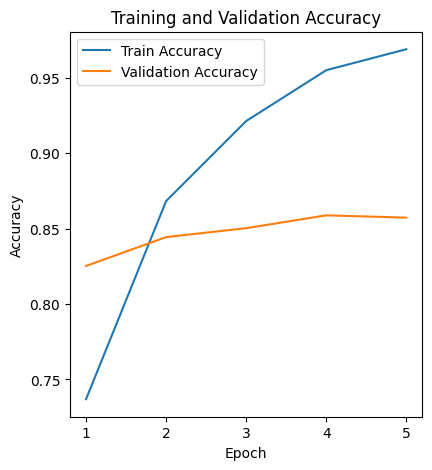

Best Validation Loss:  0.4276513604256875 Epoch:  2
Best Training Loss:  0.09399034490707471 Epoch:  4
Hyperparameters:
arguments: {'base_model_name': 'r2plus1d_multiclass', 'pretrained': True, 'lr': 0.0001, 'start_epoch': 1, 'num_epochs': 6, 'layers_list': ['layer3', 'layer4', 'fc'], 'continue_epoch': False, 'num_classes': 10, 'batch_size': 25, 'n_total': 49899, 'test_n': 4990, 'val_n': 9980, 'annotation_path': '/content/drive/My Drive/dataset/annotation_dict.json', 'augmented_annotation_path': '/content/drive/My Drive/dataset/augmented_annotation_dict.json', 'model_path': '/content/drive/My Drive/dataset/model-checkpoints/', 'history_path': '/content/drive/My Drive/dataset/histories/history3.txt'}

arguments: {'base_model_name': 'r2plus1d_multiclass', 'pretrained': True, 'lr': 0.0001, 'start_epoch': 1, 'num_epochs': 6, 'layers_list': ['layer3', 'layer4', 'fc'], 'continue_epoch': False, 'num_classes': 10, 'batch_size': 25, 'n_total': 49899, 'test_n': 4990, 'val_n': 9980, 'annotation_p

ValueError: invalid literal for int() with base 10: "path': '/content/drive/My Drive/dataset/model-checkpoints/', 'history"

In [ ]:
from __future__ import print_function
from __future__ import division

import numpy as np
import copy
import time
from tqdm import tqdm
from easydict import EasyDict
from vidaug import augmentors as vidaug
from sklearn.metrics import confusion_matrix

import torch
from torch.nn import Dropout
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import os
import sys

# 确保替换为您的utils文件夹所在的父目录的完整路径
sys.path.append('/content/drive/My Drive/dataset')

# 现在尝试导入模块
from utils.checkpoints import init_session_history, save_weights, load_weights, write_history, read_history, plot_curves

# 将CUDA设备设置为默认设备（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

args = EasyDict({
    'base_model_name': 'r2plus1d_multiclass',
    'pretrained': True,

    # training/model params
    'lr': 0.0001,
    'start_epoch': 1,
    'num_epochs': 6,
    'layers_list': ['layer3', 'layer4', 'fc'],
    'continue_epoch': False,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
    # Dataset params
    'num_classes': 10,
    'batch_size': 25,
    'n_total': 49899,
    'test_n': 4990,
    'val_n': 9980,

    # Path params
    'annotation_path': base_dir+"annotation_dict.json",
    'augmented_annotation_path':base_dir+"augmented_annotation_dict.json",
    'model_path': base_dir+"model-checkpoints/",
    'history_path': base_dir+"histories/history3.txt"
})

def train_model(model, dataloaders, criterion, optimizer, args, start_epoch=1, num_epochs=25):
    """
    Trains the 3D CNN Model
    :param model: Model object that we will train
    :param base_model_name: The base name of the model
    :param dataloaders: A dictionary of train and validation dataloader
    :param criterion: Pytorch Criterion Instance
    :param optimizer: Pytorch Optimizer Instance
    :param num_epochs: Number of epochs during training
    :return: model, train_loss_history, val_loss_history, train_acc_history, val_acc_history, train_f1_score, val_f1_score, plot_epoch
    """

    # Initializes Session History in the history file
    init_session_history(args)
    since = time.time()

    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []
    train_f1_score = []
    val_f1_score = []
    plot_epoch = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(start_epoch, num_epochs):

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                train_pred_classes = []
                train_ground_truths = []
            else:
                model.eval()  # Set model to evaluate mode
                val_pred_classes = []
                val_ground_truths = []

            running_loss = 0.0
            running_corrects = 0
            train_n_total = 1

            pbar = tqdm(dataloaders[phase])
            # Iterate over data.
            for sample in pbar:
                inputs = sample["video"].to(device)
                labels = sample["action"].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, torch.max(labels, 1)[1])

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        train_pred_classes.extend(preds.detach().cpu().numpy())
                        train_ground_truths.extend(torch.max(labels, 1)[1].detach().cpu().numpy())
                    else:
                        val_pred_classes.extend(preds.detach().cpu().numpy())
                        val_ground_truths.extend(torch.max(labels, 1)[1].detach().cpu().numpy())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == torch.max(labels, 1)[1])

                pbar.set_description('Phase: {} || Epoch: {} || Loss {:.5f} '.format(phase, epoch, running_loss / train_n_total))
                train_n_total += 1

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            # Calculate elapsed time
            time_elapsed = time.time() - since
            print(phase, ' training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # For Checkpointing and Confusion Matrix
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
                val_pred_classes = np.asarray(val_pred_classes)
                val_ground_truths = np.asarray(val_ground_truths)
                val_accuracy, val_f1, val_precision, val_recall = get_acc_f1_precision_recall(
                    val_pred_classes, val_ground_truths
                )
                val_f1_score.append(val_f1)
                val_confusion_matrix = np.array_str(confusion_matrix(val_ground_truths, val_pred_classes, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
                print('Epoch: {} || Val_Acc: {} || Val_Loss: {}'.format(
                    epoch, val_accuracy, epoch_loss
                ))
                print(f'val: \n{val_confusion_matrix}')

                # Deep Copy Model if best accuracy
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

                # set current loss to val loss for write history
                val_loss = epoch_loss

            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
                train_pred_classes = np.asarray(train_pred_classes)
                train_ground_truths = np.asarray(train_ground_truths)
                train_accuracy, train_f1, train_precision, train_recall = get_acc_f1_precision_recall(
                    train_pred_classes, train_ground_truths
                )
                train_f1_score.append(train_f1)
                train_confusion_matrix = np.array_str(confusion_matrix(train_ground_truths, train_pred_classes, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
                print('Epoch: {} || Train_Acc: {} || Train_Loss: {}'.format(
                    epoch, train_accuracy, epoch_loss
                ))
                print(f'train: \n{train_confusion_matrix}')
                plot_epoch.append(epoch)

                # set current loss to train loss for write history
                train_loss = epoch_loss

        # Save Weights
        model_name = save_weights(model, args, epoch, optimizer)

        # Write History after train and validation phase
        write_history(
            args.history_path,
            model_name,
            train_loss,
            val_loss,
            train_accuracy,
            val_accuracy,
            train_f1,
            val_f1,
            train_precision,
            val_precision,
            train_recall,
            val_recall,
            train_confusion_matrix,
            val_confusion_matrix
        )

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history, train_f1_score, val_f1_score, plot_epoch

def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        i = args.batch_size

        pbar = tqdm(loader)
        for sample in pbar:
            x = sample["video"].to(device=device)
            y = sample["action"].to(device=device)

            scores = model(x)
            predictions = scores.argmax(1)
            y = y.argmax(1)

            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

            pbar.set_description('Progress: {}'.format(i/args.test_n))
            i += args.batch_size

        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')

    model.train()

if __name__ == "__main__":
    print("PyTorch Version: ", torch.__version__)
    print("Torchvision Version: ", torchvision.__version__)
    print("Current Device: ", torch.cuda.current_device())
    print("Device: ", torch.cuda.device(0))
    print("Cuda Is Available: ", torch.cuda.is_available())
    print("Device Count: ", torch.cuda.device_count())

    # Initialize R(2+1)D Model
    model = models.video.r2plus1d_18(pretrained=args.pretrained, progress=True)

    # change final fully-connected layer to output 10 classes
    for param in model.parameters():
        param.requires_grad = False

    # Get the number of features before modifying the fc layer
    num_ftrs = model.fc.in_features

    # Adding dropout layer before the final fully connected layer
    dropout_rate = 0.5  # You can adjust the dropout rate here
    model.fc = nn.Sequential(
        nn.Dropout(dropout_rate),
        nn.Linear(num_ftrs, args.num_classes)
    )


    for name, param in model.named_parameters():
        for layer in args.layers_list:
            if layer in name:
                param.requires_grad = True
    # New Model is trained with 128x176 images
    # Calculation:
    model.fc = nn.Linear(num_ftrs, args.num_classes, bias=True)
    print(model)

    params_to_update = model.parameters()
    print("Params to learn:")
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)

    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0) / 1024 ** 3, 1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0) / 1024 ** 3, 1), 'GB')
        print(" ")

    # Transforms
    sometimes = lambda aug: vidaug.Sometimes(0.5, aug)  # Used to apply augmentor with 50% probability
    video_augmentation = vidaug.Sequential([
        sometimes(vidaug.Salt()),
        sometimes(vidaug.Pepper()),
    ], random_order=True)

    #Load Dataset
    basketball_dataset = BasketballDataset(annotation_dict=args.annotation_path,
                                           augmented_dict=args.augmented_annotation_path)

    train_subset, test_subset = random_split(
    basketball_dataset, [args.n_total-args.test_n, args.test_n], generator=torch.Generator().manual_seed(1))

    train_subset, val_subset = random_split(
        train_subset, [args.n_total-args.test_n-args.val_n, args.val_n], generator=torch.Generator().manual_seed(1))

    train_loader = DataLoader(dataset=train_subset, shuffle=True, batch_size=args.batch_size)
    val_loader = DataLoader(dataset=val_subset, shuffle=False, batch_size=args.batch_size)
    test_loader = DataLoader(dataset=test_subset, shuffle=False, batch_size=args.batch_size)

    dataloaders_dict = {'train': train_loader, 'val': val_loader}

    # Train
    optimizer_ft = optim.Adam(params_to_update, lr=args.lr)

    criterion = nn.CrossEntropyLoss()

    if args.continue_epoch:
        model = load_weights(model, args)

    if torch.cuda.is_available():
        # Put model into device after updating parameters
        model = model.to(device)
        criterion = criterion.to(device)

    # Train and evaluate
    model, train_loss_history, val_loss_history, train_acc_history, val_acc_history, train_f1_score, val_f1_score, plot_epoch = train_model(model,
                                                                                                                                            dataloaders_dict,
                                                                                                                                            criterion,
                                                                                                                                            optimizer_ft,
                                                                                                                                            args,
                                                                                                                                            start_epoch=args.start_epoch,
                                                                                                                                            num_epochs=args.num_epochs)

        # 将数据从 GPU 转移至 CPU 并转换为 NumPy 数组，以便绘图
    train_acc = [x.cpu().numpy() for x in train_acc_history]
    val_acc = [x.cpu().numpy() for x in val_acc_history]
    epochs = range(1, len(train_acc_history) + 1)

    # 绘制训练和验证准确率图
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    print("Best Validation Loss: ", min(val_loss_history), "Epoch: ", val_loss_history.index(min(val_loss_history)))
    print("Best Training Loss: ", min(train_loss_history), "Epoch: ", train_loss_history.index(min(train_loss_history)))

    # Read History
    read_history(args.history_path)

    # Check Accuracy with Test Set
    check_accuracy(test_loader, model)


In [ ]:

    # Check Accuracy with Test Set
    check_accuracy(test_loader, model)

Progress: 1.002004008016032: 100%|██████████| 200/200 [1:03:47<00:00, 19.14s/it]


Got 4242 / 4990 with accuracy 85.01


In [ ]:
def check_accuracy(loader, model, device):
    model.eval()  # Set model to evaluation mode

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(loader, desc="Evaluating")
        for sample in pbar:
            videos = sample["video"].to(device)
            labels = sample["action"].to(device)

            # Compute model output
            outputs = model(videos)
            _, preds = torch.max(outputs, 1)

            # 如果标签是独热编码，需要转换它们为类别索引
            if labels.ndim > 1 and labels.size(1) > 1:
                labels = labels.argmax(dim=1)

            # Append predictions and labels
            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
    cm = confusion_matrix(all_labels, all_predictions)

    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

    model.train()  # Set model back to training mode

# Usage example
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

check_accuracy(test_loader, model, device)

Evaluating: 100%|██████████| 200/200 [06:04<00:00,  1.82s/it]

Accuracy: 85.01%
Precision: 0.8741
Recall: 0.8537
F1 Score: 0.8618
Confusion Matrix:
[[ 477    6    5    0    7    3    3    2    0    6]
 [   5  487    3    3    3    4    0    2    0    0]
 [   1    0  529    4    2    1    4    2    0   54]
 [   0    5   16  311    0    5    4    0    0    6]
 [   2    4    0    0  218    1    0    0    0    0]
 [   4   18    8   14    2  203    2    1    6   14]
 [   0    3   16    3    0    5  254    4   40   70]
 [   2    1    2    0    0    0    2  316    2   11]
 [   3    4    4    0    0    2   29    4  434  138]
 [   3    4   69    1    0    4   27    4   59 1013]]


CONV-LSTM Model

資料載入

In [ ]:
import json
import numpy as np
import cv2

import torch
from torch.utils.data import Dataset
from torchvision import transforms

base_dir = '/content/drive/My Drive/dataset/'

class VideoDataset(Dataset):
    """SpaceJam: a Dataset for Basketball Action Recognition."""

    def __init__(self, annotation_dict, augmented_dict, video_dir=base_dir+"examples/", augmented_dir=base_dir+"augmented-examples/", augment=True, transform=None, poseData=False):
        with open(annotation_dict) as f:
            self.video_list = list(json.load(f).items())

        if augment:
            self.augment = augment
            with open(augmented_dict) as f:
                augmented_list = list(json.load(f).items())
            self.augmented_dir = augmented_dir
            # extend with augmented data
            self.video_list.extend(augmented_list)

        self.video_dir = video_dir
        self.poseData = poseData
        self.transform = transform

    def __len__(self):
        # 返回视频列表的长度作为数据集的长度
        return len(self.video_list)

    def __getitem__(self, idx):
      video_id = self.video_list[idx][0]
      encoding = int(self.video_list[idx][1])
      video = self.VideoToNumpy(video_id)
      if video is None:
        return None
      sample = {'video_id': video_id, 'video': torch.from_numpy(video).float(), 'action': encoding, 'class': encoding}
      return sample

    def VideoToNumpy(self, video_id):
      video_path = os.path.join(self.video_dir, video_id + ".mp4")
      video = cv2.VideoCapture(video_path)
      if not video.isOpened():
        augmented_video_path = os.path.join(self.augmented_dir, video_id + ".mp4")
        video = cv2.VideoCapture(augmented_video_path)
        if not video.isOpened():
            print(f"Cannot read video: {video_path} or {augmented_video_path}")
            return None

      video_frames = []
      while True:
        success, frame = video.read()
        if not success:
            break
        frame = frame.astype(np.float32) / 255.0
        frame = np.transpose(frame, (2, 0, 1))
        video_frames.append(frame)

      video.release()
      # 如果帧数不足16，重复最后一帧直到达到16帧
      while len(video_frames) < 16:
        video_frames.append(video_frames[-1])  # 假设视频至少有一帧

      return np.array(video_frames)


if __name__ == "__main__":
    video_dataset = VideoDataset(annotation_dict=base_dir + "annotation_dict.json",
                                 augmented_dict=base_dir + "augmented_annotation_dict.json")
    print(video_dataset[1]['action'])
    print(video_dataset[1]['class'])
    print(len(video_dataset))


8
8
49899


參數設置

In [ ]:
from easydict import EasyDict

base_dir = '/content/drive/My Drive/dataset/'  # 确保这个路径是正确的

args = EasyDict({
    'base_model_name': 'conv-lstm',
    'pretrained': True,
    'lr': 0.0001,
    'start_epoch': 1,
    'num_epochs': 6,
    'layers_list': ['layer3', 'layer4', 'fc'],
    'continue_epoch': False,
    'num_classes': 10,
    'batch_size': 25,
    'n_total': 49899,
    'test_n': 4990,
    'val_n': 9980,
    'annotation_path': base_dir + "annotation_dict.json",
    'augmented_annotation_path': base_dir + "augmented_annotation_dict.json",
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
})


模型定義

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class ConvLSTM(nn.Module):
    def __init__(self, num_classes, hidden_size=256, lstm_layers=1, dropout_rate=0.5):
        super(ConvLSTM, self).__init__()
        self.resnet = models.resnet18(pretrained=True)  # 使用ResNet18作为特征提取器
        self.resnet.fc = nn.Identity()  # 移除原有的全连接层
        self.lstm = nn.LSTM(512, hidden_size, lstm_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)  # 添加dropout层
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x: (batch_size, timesteps, C, H, W)
        b, t, C, H, W = x.size()
        c_in = x.view(b * t, C, H, W)  # 合并batch和timesteps
        c_out = self.resnet(c_in)  # (b*t, 512)
        r_out = c_out.view(b, t, -1)  # 重新分割batch和timesteps
        h_n, _ = self.lstm(r_out)  # 只使用最后的hidden state
        h_n = self.dropout(h_n[:, -1, :])  # 在LSTM输出后应用dropout
        output = self.fc(h_n)  # 取LSTM输出的最后一个时间步
        return output



Dataloader設置

In [ ]:
from torch.utils.data import DataLoader, random_split

# 假设args包含所有必要的参数
video_dataset = VideoDataset(annotation_dict=args.annotation_path, augmented_dict=args.augmented_annotation_path)

# 确定训练集、验证集和测试集的大小
train_size = 34929
val_size = 9980
test_size = 4990  # 测试集大小

# 确保总大小与分配匹配
total_size = train_size + val_size + test_size
assert total_size == len(video_dataset), "Size mismatch"

# 划分数据集
train_val_dataset, test_dataset = random_split(video_dataset, [train_size + val_size, test_size], generator=torch.Generator().manual_seed(42))
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

# 创建DataLoaders
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)



訓練

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 12.3 MB/s eta 0:00:00


In [ ]:
!pip install tqdm

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torchmetrics import ConfusionMatrix, Accuracy, Precision, Recall, F1Score
from tqdm import tqdm
import os
base_dir = '/content/drive/My Drive/dataset/'
# 初始化模型、优化器和损失函数
model = ConvLSTM(num_classes=args.num_classes).to(args.device)
optimizer = Adam(model.parameters(), lr=args.lr)
criterion = nn.CrossEntropyLoss()

# 初始化评价指标
metrics = {
    'accuracy': Accuracy(num_classes=args.num_classes, average='macro', task='multiclass').to(args.device),
    'precision': Precision(num_classes=args.num_classes, average='macro', task='multiclass').to(args.device),
    'recall': Recall(num_classes=args.num_classes, average='macro', task='multiclass').to(args.device),
    'f1': F1Score(num_classes=args.num_classes, average='macro', task='multiclass').to(args.device)
}

# 准备数据加载器
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

# 准备存储训练历史的文件夹和文件
history_dir = os.path.join(base_dir+"histories")
if not os.path.exists(history_dir):
    os.makedirs(history_dir)
history_path = os.path.join(history_dir, "historyLSTM.txt")

# 添加精确度、召回率、F1分数和混淆矩阵到头部信息
with open(history_path, "w") as f:
    f.write("epoch,train_loss,train_accuracy,train_precision,train_recall,train_f1,validation_loss,validation_accuracy,validation_precision,validation_recall,validation_f1\n")


def process_epoch(mode, model, loader, optimizer, criterion, device, metrics, history_file, epoch=None):
    if mode == 'train':
        model.train()
    else:
        model.eval()

    total_loss = 0
    confusion_matrix = ConfusionMatrix(num_classes=args.num_classes, task="multiclass").to(device)
    progress_bar = tqdm(loader, desc=f"Epoch {epoch} [{mode.upper()}]", total=len(loader))

    for data in progress_bar:
        videos = data['video'].to(device)
        labels = data['action'].to(device)

        if mode == 'train':
            optimizer.zero_grad()

        with torch.set_grad_enabled(mode == 'train'):
            outputs = model(videos)
            loss = criterion(outputs, labels)
            if mode == 'train':
                loss.backward()
                optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        confusion_matrix.update(predicted, labels)

        for metric in metrics.values():
            metric(outputs, labels)

        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(loader)
    metrics_results = {name: metric.compute().item() for name, metric in metrics.items()}
    metrics_results['loss'] = avg_loss
    cm = confusion_matrix.compute()

    if history_file and epoch is not None:
        history_file.write(f"{epoch},{avg_loss},{metrics_results['accuracy']},{metrics_results['precision']},{metrics_results['recall']},{metrics_results['f1']}\n")

    return metrics_results, cm

#训练和验证循环调用
with open(history_path, "a") as f:
    for epoch in range(args.start_epoch, args.num_epochs + 1):
        train_metrics, train_cm = process_epoch('train', model, train_loader, optimizer, criterion, args.device, metrics, None, epoch)
        val_metrics, val_cm = process_epoch('validate', model, val_loader, None, criterion, args.device, metrics, None, epoch)

        # 将训练和验证的结果写入文件
        f.write(f"{epoch},{train_metrics['loss']},{train_metrics['accuracy']},{train_metrics['precision']},{train_metrics['recall']},{train_metrics['f1']},")
        f.write(f"{val_metrics['loss']},{val_metrics['accuracy']},{val_metrics['precision']},{val_metrics['recall']},{val_metrics['f1']}\n")

        print(f"Train CM Epoch {epoch}:\n{train_cm}")
        print(f"Validation CM Epoch {epoch}:\n{val_cm}")



# 选项：完成所有训练后进行最终测试评估
def evaluate(model, loader, criterion, device, metrics):
    model.eval()
    total_loss = 0
    confusion_matrix = ConfusionMatrix(num_classes=args.num_classes, task="multiclass").to(device)

    with torch.no_grad():
        for data in loader:
            videos = data['video'].to(device)
            labels = data['action'].to(device)
            outputs = model(videos)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            confusion_matrix.update(predicted, labels)
            for metric in metrics.values():
                metric(outputs, labels)

    avg_loss = total_loss / len(loader)
    metrics_results = {name: metric.compute().item() for name, metric in metrics.items()}
    metrics_results['loss'] = avg_loss
    cm = confusion_matrix.compute()

    return metrics_results, cm

metrics, test_cm = evaluate(model, test_loader, criterion, args.device, metrics)
print(f"Final Test Metrics: {metrics}")
print(f"Test Confusion Matrix:\n{test_cm}")




Epoch 1 [VALIDATE]: 100%|██████████| 400/400 [1:19:35<00:00, 11.94s/it, loss=0.511]


Train CM Epoch 1:
tensor([[2329,  462,   56,    8,  129,   20,   45,  205,   41,  185],
        [ 387, 2343,  104,  125,  119,  111,   40,  267,   54,  170],
        [  20,   10, 2920,  150,    1,   20,  127,    6,   29,  938],
        [  11,   42,  319, 1580,    2,  109,   86,    2,   24,  259],
        [ 465,  372,    8,   15,  471,   29,    3,   57,   23,   77],
        [  51,   64,  153,  293,   24,  584,  104,    6,   87,  293],
        [  35,    6,  204,   70,    4,   30, 1352,   21,  292,  690],
        [ 325,  471,   52,   12,   25,    7,   52, 1300,   51,  225],
        [  32,   16,   42,   17,   11,   29,  203,   12, 2361, 1741],
        [  56,   22,  613,   66,   11,   66,  349,   36, 1017, 5971]],
       device='cuda:0')
Validation CM Epoch 1:
tensor([[ 688,   23,    7,    0,   70,   11,   30,  121,    5,   25],
        [  25,  804,   16,    6,   32,   53,   10,   90,    3,   27],
        [   0,    1,  909,    8,    0,    1,   45,    7,    3,  175],
        [   0,   32,   5

Epoch 2 [VALIDATE]: 100%|██████████| 400/400 [02:54<00:00,  2.30it/s, loss=0.251]


Train CM Epoch 2:
tensor([[2975,  117,   27,    3,  114,   29,   41,   99,   14,   61],
        [ 122, 3088,   39,  109,   71,  111,   12,   94,   13,   61],
        [  17,   10, 3470,   52,    0,   23,   52,   12,    4,  581],
        [   5,   63,   86, 2081,    2,  108,   34,    3,    4,   48],
        [ 214,  124,    6,    5, 1111,   27,    0,   17,    2,   14],
        [  44,   84,   59,  126,   30, 1169,   30,    7,   42,   68],
        [  37,    6,   80,   32,    0,   36, 1878,   26,  204,  405],
        [ 102,  101,   16,    5,    8,    6,   35, 2094,   37,  116],
        [  22,   15,   16,    4,    7,   26,  229,   29, 2957, 1159],
        [  46,   24,  477,   31,    3,   52,  325,   47,  880, 6322]],
       device='cuda:0')
Validation CM Epoch 2:
tensor([[ 858,   15,    5,    1,   41,    2,   20,   14,    5,   19],
        [  46,  897,    1,   12,   11,   47,   11,   14,    9,   18],
        [   0,   10,  869,   18,    0,    6,   64,    5,    3,  174],
        [   1,   11,   1

Epoch 3 [VALIDATE]: 100%|██████████| 400/400 [02:54<00:00,  2.29it/s, loss=0.403]


Train CM Epoch 3:
tensor([[3208,   55,   16,    2,   72,   13,   26,   38,   16,   34],
        [  63, 3379,   23,   66,   33,   51,    8,   58,   15,   24],
        [  16,   10, 3623,   33,    2,   20,   42,    9,    1,  465],
        [   0,   44,   54, 2207,    0,   92,   10,    3,    2,   22],
        [ 106,   61,    3,    1, 1305,   23,    0,   10,    2,    9],
        [  31,   56,   39,   90,   18, 1326,   28,    7,   17,   47],
        [  36,    7,   40,   17,    0,   19, 2063,   25,  175,  322],
        [  48,   46,   16,    2,    3,    5,   23, 2283,   16,   78],
        [  17,    9,    8,    3,    3,   22,  180,   11, 3224,  987],
        [  26,   19,  384,   24,    5,   24,  281,   43,  736, 6665]],
       device='cuda:0')
Validation CM Epoch 3:
tensor([[ 940,    4,   11,    0,    3,    6,    1,    9,    0,    6],
        [  71,  864,   18,   18,   13,   35,    1,   33,    3,   10],
        [   1,    1, 1074,    2,    0,    2,    1,    0,    0,   68],
        [   4,    8,   5

Epoch 4 [VALIDATE]: 100%|██████████| 400/400 [02:54<00:00,  2.29it/s, loss=0.16]


Train CM Epoch 4:
tensor([[3307,   33,   10,    3,   46,    4,   21,   23,   13,   20],
        [  33, 3536,    8,   40,   15,   38,    2,   29,    8,   11],
        [  12,    4, 3792,   28,    0,   12,   30,    4,    5,  334],
        [   2,   34,   31, 2284,    1,   46,   14,    1,    1,   20],
        [  65,   25,    0,    1, 1408,    7,    0,    4,    2,    8],
        [  13,   39,   26,   67,   10, 1444,   11,    5,   21,   23],
        [  24,    5,   30,   14,    0,   11, 2188,   13,  147,  272],
        [  35,   32,    8,    2,    4,    6,   13, 2352,   18,   50],
        [  10,    5,    8,    1,    2,   16,  134,   16, 3448,  824],
        [  13,    7,  296,   12,    3,   23,  256,   26,  630, 6941]],
       device='cuda:0')
Validation CM Epoch 4:
tensor([[ 844,   12,    2,    0,   74,    0,   18,   18,    4,    8],
        [  13,  929,    5,   31,   26,   20,    7,   21,    6,    8],
        [   0,    1,  878,   11,    0,    6,   19,   10,    3,  221],
        [   0,    4,   1

Epoch 5 [VALIDATE]: 100%|██████████| 400/400 [02:54<00:00,  2.30it/s, loss=0.458]


Train CM Epoch 5:
tensor([[3362,   21,    3,    0,   36,   10,    6,   17,    9,   16],
        [  25, 3572,    9,   31,   16,   35,    0,   17,    5,   10],
        [   5,    7, 3838,   24,    1,    6,   27,    2,    2,  309],
        [   0,   20,   34, 2320,    0,   33,    8,    0,    1,   18],
        [  44,   17,    0,    0, 1443,    7,    0,    5,    0,    4],
        [  12,   32,   12,   52,    8, 1506,    8,    2,   10,   17],
        [  15,    5,   28,   15,    0,    5, 2300,    6,  111,  219],
        [  24,   19,    6,    1,    0,    1,   10, 2412,   15,   32],
        [  11,    7,    5,    2,    2,   15,  126,   13, 3655,  628],
        [  17,    3,  272,   10,    1,   19,  193,   26,  486, 7180]],
       device='cuda:0')
Validation CM Epoch 5:
tensor([[ 880,   18,    4,    0,   15,    0,   15,   26,    5,   17],
        [   7,  995,   11,   10,    2,   10,    2,   14,    5,   10],
        [   0,    1, 1013,    5,    0,    0,    8,    0,    3,  119],
        [   2,    9,   3

Epoch 6 [VALIDATE]: 100%|██████████| 400/400 [02:56<00:00,  2.27it/s, loss=0.34]


Train CM Epoch 6:
tensor([[3389,   21,    6,    0,   24,    5,    7,   13,    6,    9],
        [  15, 3618,    7,   21,    8,   19,    0,   19,    3,   10],
        [   4,    6, 3951,   18,    0,    9,   18,    7,    0,  208],
        [   0,   17,   20, 2347,    0,   31,    7,    0,    1,   11],
        [  17,   13,    0,    1, 1474,    6,    0,    0,    2,    7],
        [  14,   19,    5,   41,    9, 1536,    9,    1,   10,   15],
        [  13,    0,   20,    7,    0,    5, 2386,    5,  103,  165],
        [  13,   11,    4,    0,    1,    2,    7, 2453,    8,   21],
        [   8,    2,    4,    0,    3,    5,  104,   10, 3842,  486],
        [  12,    4,  197,    9,    2,   12,  149,   13,  385, 7424]],
       device='cuda:0')
Validation CM Epoch 6:
tensor([[ 882,   34,    9,    0,    8,    6,    9,   12,    5,   15],
        [   6,  999,    5,    4,   10,   24,    0,    5,    5,    8],
        [   1,    1,  971,    9,    0,    6,    8,    0,    1,  152],
        [   1,   12,   1

Error Analysis(R(2+1)D CNN Model)

Class          Precision Recall    F1-Score  Accuracy  
block          0.96      0.94      0.95      0.94      
pass           0.92      0.96      0.94      0.96      
run            0.81      0.89      0.85      0.89      
dribble        0.93      0.90      0.91      0.90      
shoot          0.94      0.97      0.95      0.97      
ball in hand   0.89      0.75      0.81      0.75      
defense        0.78      0.64      0.71      0.64      
pick           0.94      0.94      0.94      0.94      
no_action      0.80      0.70      0.75      0.70      
walk           0.77      0.86      0.81      0.86      


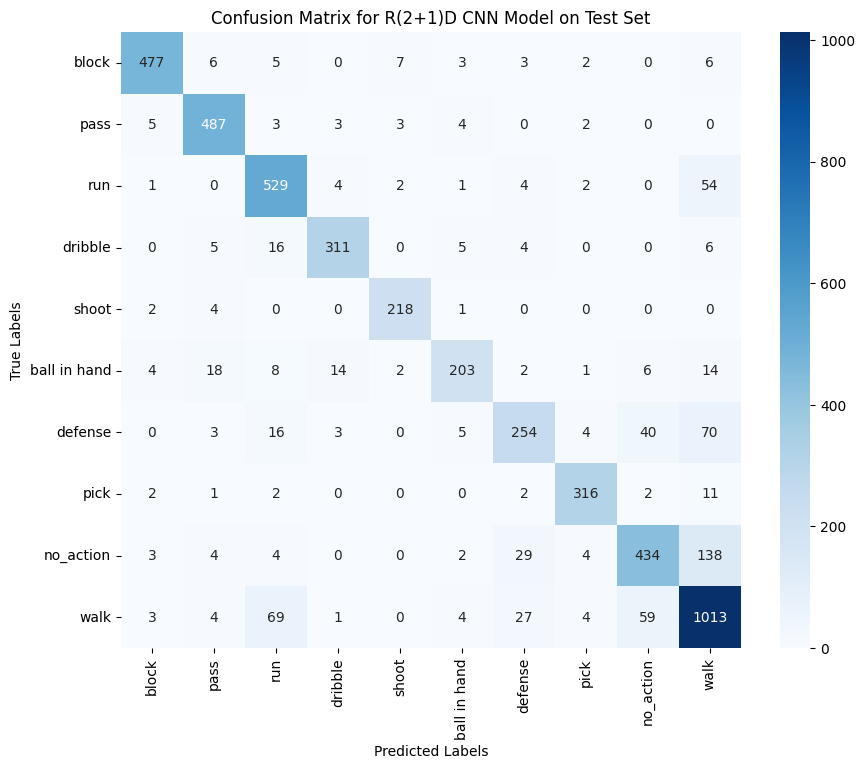

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 定义你的混淆矩阵和标签
conf_matrix = np.array([
    [477, 6, 5, 0, 7, 3, 3, 2, 0, 6],
    [5, 487, 3, 3, 3, 4, 0, 2, 0, 0],
    [1, 0, 529, 4, 2, 1, 4, 2, 0, 54],
    [0, 5, 16, 311, 0, 5, 4, 0, 0, 6],
    [2, 4, 0, 0, 218, 1, 0, 0, 0, 0],
    [4, 18, 8, 14, 2, 203, 2, 1, 6, 14],
    [0, 3, 16, 3, 0, 5, 254, 4, 40, 70],
    [2, 1, 2, 0, 0, 0, 2, 316, 2, 11],
    [3, 4, 4, 0, 0, 2, 29, 4, 434, 138],
    [3, 4, 69, 1, 0, 4, 27, 4, 59, 1013]
])

labels = ['block', 'pass', 'run', 'dribble', 'shoot', 'ball in hand', 'defense', 'pick', 'no_action', 'walk']

# 模拟实际标签和预测标签
y_true = []
y_pred = []
for i, row in enumerate(conf_matrix):
    for j, count in enumerate(row):
        y_true.extend([i] * count)
        y_pred.extend([j] * count)

# 生成分类报告
report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)

# 计算每个类别的准确率
accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# 打印分类报告并加入每个类别的准确率
print(f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F1-Score':<10}{'Accuracy':<10}")
for label in labels:
    precision = report[label]['precision']
    recall = report[label]['recall']
    f1_score = report[label]['f1-score']
    accuracy = accuracies[labels.index(label)]
    print(f"{label:<15}{precision:<10.2f}{recall:<10.2f}{f1_score:<10.2f}{accuracy:<10.2f}")

# 绘制混淆矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for R(2+1)D CNN Model on Test Set')
plt.show()


Error Analysis(CONV-LSTM Model)

Class          Precision Recall    F1-Score  Accuracy  
block          0.96      0.91      0.93      0.91      
pass           0.92      0.93      0.92      0.93      
run            0.84      0.81      0.83      0.81      
dribble        0.93      0.89      0.91      0.89      
shoot          0.95      0.92      0.93      0.92      
ball in hand   0.74      0.84      0.79      0.84      
defense        0.79      0.67      0.72      0.67      
pick           0.93      0.89      0.91      0.89      
no_action      0.75      0.73      0.74      0.73      
walk           0.75      0.83      0.79      0.83      


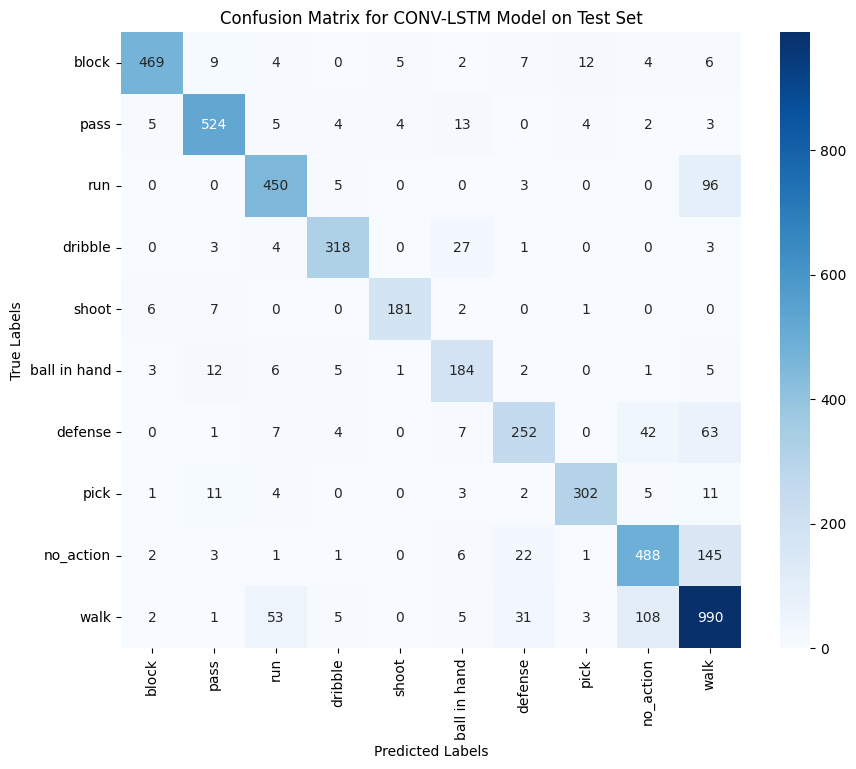

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 定义你的混淆矩阵和标签
conf_matrix = np.array([
    [469,   9,   4,   0,   5,   2,   7,  12,   4,   6],
        [  5, 524,   5,   4,   4,  13,   0,   4,   2,   3],
        [  0,   0, 450,   5,   0,   0,   3,   0,   0,  96],
        [  0,   3,   4, 318,   0,  27,   1,   0,   0,   3],
        [  6,   7,   0,   0, 181,   2,   0,   1,   0,   0],
        [  3,  12,   6,   5,   1, 184,   2,   0,   1,   5],
        [  0,   1,   7,   4,   0,   7, 252,   0,  42,  63],
        [  1,  11,   4,   0,   0,   3,   2, 302,   5,  11],
        [  2,   3,   1,   1,   0,   6,  22,   1, 488, 145],
        [  2,   1,  53,   5,   0,   5,  31,   3, 108, 990]
])

labels = ['block', 'pass', 'run', 'dribble', 'shoot', 'ball in hand', 'defense', 'pick', 'no_action', 'walk']

# 模拟实际标签和预测标签
y_true = []
y_pred = []
for i, row in enumerate(conf_matrix):
    for j, count in enumerate(row):
        y_true.extend([i] * count)
        y_pred.extend([j] * count)

# 生成分类报告
report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)

# 计算每个类别的准确率
accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# 打印分类报告并加入每个类别的准确率
print(f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F1-Score':<10}{'Accuracy':<10}")
for label in labels:
    precision = report[label]['precision']
    recall = report[label]['recall']
    f1_score = report[label]['f1-score']
    accuracy = accuracies[labels.index(label)]
    print(f"{label:<15}{precision:<10.2f}{recall:<10.2f}{f1_score:<10.2f}{accuracy:<10.2f}")

# 绘制混淆矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for CONV-LSTM Model on Test Set')
plt.show()
